In [1]:
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tnrange, tqdm_notebook
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import warnings 

# Lab

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# ## Subset selection in python
# 
# 
# This notebook explores common methods for performing subset selection on a regression model, namely
# 
#     Best subset selection
#     Forward stepwise selection
#     Criteria for choosing the optimal model
#         Cp, AIC, BIC, R2adj
# 
# ## [Lab 2: Ridge Regression](#Ridge-Regression)
# [Hitters Data](#Read-training-and-Test-data)
# - [The Lasso](#The-LASSO)
# - [Lab 3: Principal Components](#Principal-Components)
# - [Lab 3: Partial Least Squares](#Partial-Least-Squares)

# In[19]:


import os
os.chdir("C:\\Users\\AST\\OneDrive - Southern Methodist University\\Documents\\Documents\\SMU\\Machine Learning\\ISL Data\\IntroStatLearn-master\\data\\")
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('ggplot')


# # Credit Data
# The Credit data set displayed in Figure records balance (average credit card debt for a number of individuals) as well as several quantitative predictors: age, cards (number of credit cards), education (years of education), income (in thousands of dollars), limit (credit limit), and rating (credit rating). Each panel of Figure 3.6 is a scatterplot for a pair of variables whose identities are given by the corresponding row and column labels. For example, the scatterplot directly to the right of the word “Balance” depicts balance versus age, while the plot directly to the right of “Age” corresponds to age versus cards. In addition to these quantitative variables, we also have four qualitative variables: gender, student (student status), status (marital status), and ethnicity (Caucasian, African American or Asian).
# [Statsmodel linear regression ](#first)

# In[217]:


credit = pd.read_csv('Credit.csv', usecols=list(range(1,12)))
credit.head(3)


# In[ ]:





# In[218]:


sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);


# ## Statsmodel linear regression 
# <a id='first'></a>
# 
# Least squares coefficient estimates associated with the regression of balance onto ethnicity in the Credit data set. The linear model is given in (3.30). That is, ethnicity is encoded via two dummy variables
# 

# In[221]:


#Setting up the X and Y variables, adding constant term for intercept
Y = credit.Balance
X = credit[['Ethnicity_Asian','Ethnicity_Caucasian']]
X = sm.add_constant(X)
X.head()


# In[222]:


# OLS Table
model_1 = sm.OLS(Y, X)
result_1 = model_1.fit()
result_1.summary()


# In[ ]:


credit = pd.read_csv('Credit.csv', usecols=list(range(1,12))


# In[220]:


credit = pd.get_dummies(credit, columns = ['Gender', 'Student','Married','Ethnicity'],drop_first = True)
credit.head(5)


# ### Define function for fitting linear regression (Sklearn)¶

# In[223]:


def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared


# ## Implementing Best subset selection (using itertools.combinations)

# In[224]:


#Importing tqdm for the progress bar
from tqdm import tnrange, tqdm_notebook

#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11
RSS_list, R_squared_list, feature_list = [],[], []
numb_features = []

#Looping over k = 1 to k = 11 features in X
for k in tnrange(1,len(X.columns) + 1, desc = 'Loop...'):

    #Looping over all possible combinations: from 11 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = fit_linear_reg(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})


# ### Finding the best subsets for each number of features
# 
# #### Using the smallest RSS value, or the largest R_squared value
# 

# In[225]:


df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))


# ### Adding columns to the dataframe with RSS and R squared values of the best subset

# In[226]:


df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)
df.head()


# ## Plotting the best subset selection process

# In[227]:


fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()


# ## Forward stepwise selection

# In[228]:


#Initialization variables
Y = credit.Balance
X = credit.drop(columns = 'Balance', axis = 1)
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()


# In[229]:


print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])


# ## Comparing models: AIC, BIC, Mallows'CP

# In[231]:


df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index


# ### Computing the C_p, AIC, BIC and R-square adjusted

# In[232]:


#Initializing useful variables
m = len(Y)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1


# In[233]:


df1['R_squared_adj'].idxmax()
df1['R_squared_adj'].max()


# ### Plotting the computed values as a function of number of features

# In[234]:


variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.show()


# # Ridge Regression

# 

# ## Read the Hitters data
# 
# Description
# 
# Baseball Data
# Description
# 
# Major League Baseball Data from the 1986 and 1987 seasons.
# Usage
# 
# Hitters
# 
# Format
# 
# A data frame with 322 observations of major league players on the following 20 variables.
# 
# AtBat
# 
#     Number of times at bat in 1986
# Hits
# 
#     Number of hits in 1986
# HmRun
# 
#     Number of home runs in 1986
# Runs
# 
#     Number of runs in 1986
# RBI
# 
#     Number of runs batted in in 1986
# Walks
# 
#     Number of walks in 1986
# Years
# 
#     Number of years in the major leagues
# CAtBat
# 
#     Number of times at bat during his career
# CHits
# 
#     Number of hits during his career
# CHmRun
# 
#     Number of home runs during his career
# CRuns
# 
#     Number of runs during his career
# CRBI
# 
#     Number of runs batted in during his career
# CWalks
# 
#     Number of walks during his career
# League
# 
#     A factor with levels A and N indicating player's league at the end of 1986
# Division
# 
#     A factor with levels E and W indicating player's division at the end of 1986
# PutOuts
# 
#     Number of put outs in 1986
# Assists
# 
#     Number of assists in 1986
# Errors
# 
#     Number of errors in 1986
# Salary
# 
#     1987 annual salary on opening day in thousands of dollars
# NewLeague
# 
#     A factor with levels A and N indicating player's league at the beginning of 1987
# 
# Source
# 
# This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York. 
# 

# In[ ]:


hitters = pd.read_csv('Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'
hitters.info()


# In[235]:


hitters.head()


# In[236]:


dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())


# #### Define X and y matrices:
#     Drop the column with the independent variable (Salary), and qualitative columns 
# 

# In[6]:


y = hitters.Salary
X_ = hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()


# X.head(5)

# ### Read training and Test data

# ### SKIP THIS
# X_train = pd.read_csv('Hitters_X_train.csv', index_col=0)
# y_train = pd.read_csv('Hitters_y_train.csv', index_col=0)
# X_test = pd.read_csv('Hitters_X_test.csv', index_col=0)
# y_test = pd.read_csv('Hitters_y_test.csv', index_col=0)

# #### Generate Alphas to use in Ridge Regression
#     

# In[239]:


alphas = 10**np.linspace(10,-2,100)*0.5 # np.linspace(1000,-1000,100)
alphas


# In[240]:


ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)


# Output above means that there is a 19x100 matrix, 100 models each with 19 predictors

# Let's cerate the plot for when features come into the model

# In[241]:


ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')


# #### Split data into training and test sets 
# Use train_test_split from sklearn
# 

# In[242]:


from sklearn.model_selection import train_test_split

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


# # Let's use alpha=10, then fit  ridge regression on the training data to predict test MSE

# In[244]:


ridge2 = Ridge(alpha = 5, normalize = True) 
ridge2.fit(X_train, y_train)            
pred2 = ridge2.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred2))          # Calculate the test MSE


# #### MSE_test=121263.26 for alpha = 10 
# Now let's see for alpha= $10^{5}$, look for shrinkage hence more biased:

# In[248]:


ridge3 = Ridge(alpha = 10**5, normalize = True)
ridge3.fit(X_train, y_train)             
pred3 = ridge3.predict(X_test)           
print(pd.Series(ridge3.coef_, index = X.columns)) 
print(mean_squared_error(y_test, pred3))          


# Above number indicates a big shrinkage, very small coefficients. 
# ##### Q: Is the model more or or less biased in this case?
# Compare this result to alpha=10 MSE
# ### Remember OLS estimate is alpha=0

# In[246]:


ridge2 = Ridge(alpha = 0, normalize = True)
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge2.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))           # Calculate the test MSE


# Is this an improvement over alpha=10 value?
# If not reduce the alpha.

# ### Let's use cross-validation to choose the tuning parameter alpha. 
# RidgeCV() is the cross-validated ridge regression function. For the value of alpha from running this, we can check the test MSE

# In[247]:


ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_


# Once we have the value of alpha, we can calculate new test MSE

# In[249]:


ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.fit(X_train, y_train)
mean_squared_error(y_test, ridge4.predict(X_test))


# ### Ridge Regression on full data set with the chosen alpha

# In[250]:


ridge4.fit(X, y)
pd.Series(ridge4.coef_, index = X.columns)
mean_squared_error(y, ridge4.predict(X))


# In[251]:


ridge4.coef_


# ## The LASSO
# Check to see if the lasso gives a better model (different norm space), i.e.,  a more accurate or a more interpretable model than ridge regression. 
# 

# In[158]:


from sklearn.preprocessing import scale


# In[252]:


lasso = Lasso(max_iter = 10000, normalize = True) # can change the max iteration x10 or 100
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')


# Q: What's the above graph telling us?  
#     A:some coefficients are zero
# Now let's look at MSE_test to see if it is any better!

# In[253]:


lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
mean_squared_error(y_test, lasso.predict(X_test))


# Q: Would you use the Lasso in this case?
#     A: Much smaller number of features

# In[254]:


pd.Series(lasso.coef_, index=X.columns)


# ## Principal Components 
# Use sklearn module and PCA() function, primarily. 
# To continue from above we will use PCA to predict Salary. 

# check to see if there are any missing values in the data

# In[13]:


from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

hitters = pd.read_csv('Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])
#dummies.info()

y = hitters.Salary
X_ = hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.


X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
X.info()


# In[26]:


pca = PCA()
X_reduced = pca.fit_transform(scale(X))


# In[35]:


#Principal Components
pd.DataFrame(pca.components_.T).loc[:,:]


# print(X_reduced.shape)
# pd.DataFrame(X_reduced).loc[:4,:]

# 10-fold cross-validation to see how it influences the MSE:
# 

# In[40]:


from sklearn import model_selection
n = len(X_reduced)
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);


# We see that the smallest cross-validation error occurs when M=18 components are used. This is barely fewer than M=19
# 
# , which amounts to simply performing least squares, because when all of the components are used in PCR no dimension reduction occurs. However, from the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. This suggests that a model that uses just a small number of components might suffice.
# 
# We'll do a little math to get the amount of variance explained by adding each consecutive principal component:
# 

# ### Variances explained by PCA

# In[41]:


np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)


# setting M=1 explains 38.31% of the variation, in response, M=10 does 97.25
# 
# 
# ## PCA on the training data:

# In[42]:


pca2 = PCA()

# Scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*model_selection.cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);


# In[ ]:


lowest MSE_CV when M=6 components are used


# ### MSE_test CV

# In[49]:


X_reduced_test = pca2.transform(scale(X_test))[:,:7]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:7], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)


# How does this MSE compare to The ridge and lasso? Is the final model easier to interpret (no variable selection)?

# In[259]:


regr_test = LinearRegression()
regr_test.fit(X_reduced, y)
regr_test.coef_


# In[45]:




6.7.2 Partial Least Squares

Scikit-learn PLSRegression gives same results as the pls package in R when using method='oscorespls'. However, the standard method used is 'kernelpls', which we'll use here. Feel free to try out both.


# In[50]:



from sklearn.cross_decomposition import PLSRegression, PLSSVD
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)


# The lowest cross-validation error occurs when only M=2 partial least squares dimensions are used. We now evaluate the corresponding test set MSE:

# In[51]:


pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))


# The test MSE is again comparable to the test MSE obtained using ridge regression, the lasso, and PCR.

# ## Partial Least Squares
# 
# 

# In[52]:


n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

mse = []

for i in np.arange(1, 20):
    pls = PLSRegression(n_components=i)
    score = model_selection.cross_val_score(pls, scale(X_train), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

# Plot results
plt.plot(np.arange(1, 20), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1)


# The lowest cross-validation error occurs when only M=2 partial least squares dimensions are used. We now evaluate the corresponding test set MSE:

# In[53]:


pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))


# The test MSE is again comparable to the test MSE obtained using ridge regression, the lasso, and PCR.


# #6.8

## (a)

In [255]:
#random normal
x = np.random.normal(56, 6.4, 100)
e = np.random.normal(0, 3.2, 100)

## (b)

In [256]:
Y = 0.3 + 0.2*x - 0.88*x**2 + 0.43*x**3 + e

## (c)

In [257]:
# merge X and Y as a dataframe
X = pd.DataFrame(x, columns=list('X'))
y = pd.DataFrame(Y, columns=list('y'))
y = y.y

#Use X, X^2, ..., X^10 as predictors
X['X2'] = X['X']**2
X['X3'] = X['X']**3
X['X4'] = X['X']**4
X['X5'] = X['X']**5
X['X6'] = X['X']**6
X['X7'] = X['X']**7
X['X8'] = X['X']**8
X['X9'] = X['X']**9
X['X10'] = X['X']**10

In [258]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def regsubsets(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [259]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = regsubsets(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

warnings.filterwarnings('ignore') #hide warnings

Processed 10 models on 1 predictors in 0.03582501411437988 seconds.
Processed 45 models on 2 predictors in 0.12461686134338379 seconds.
Processed 120 models on 3 predictors in 0.27191781997680664 seconds.
Processed 210 models on 4 predictors in 0.431851863861084 seconds.
Processed 252 models on 5 predictors in 0.5514779090881348 seconds.
Processed 210 models on 6 predictors in 0.44208383560180664 seconds.
Processed 120 models on 7 predictors in 0.2571079730987549 seconds.
Total elapsed time: 2.137752056121826 seconds.


In [260]:
models_best

,RSS,model
1,1.221574e+07,<statsmodels.regression.linear_model.Regressio...
2,7.813299e+02,<statsmodels.regression.linear_model.Regressio...
3,7.506626e+02,<statsmodels.regression.linear_model.Regressio...
4,7.506327e+02,<statsmodels.regression.linear_model.Regressio...
5,7.004899e+02,<statsmodels.regression.linear_model.Regressio...
6,7.004317e+02,<statsmodels.regression.linear_model.Regressio...
7,7.015207e+02,<statsmodels.regression.linear_model.Regressio...


## (d)

In [261]:
#Forward Selection
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [262]:
models_fwd = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  10 models on 1 predictors in 0.037576913833618164 seconds.
Processed  9 models on 2 predictors in 0.050366878509521484 seconds.
Processed  8 models on 3 predictors in 0.024449586868286133 seconds.
Processed  7 models on 4 predictors in 0.020205020904541016 seconds.
Processed  6 models on 5 predictors in 0.014930009841918945 seconds.
Processed  5 models on 6 predictors in 0.016577959060668945 seconds.
Processed  4 models on 7 predictors in 0.013983011245727539 seconds.
Processed  3 models on 8 predictors in 0.008111715316772461 seconds.
Processed  2 models on 9 predictors in 0.005714893341064453 seconds.
Processed  1 models on 10 predictors in 0.0034058094024658203 seconds.
Total elapsed time: 0.22117376327514648 seconds.


In [263]:
#Backward Selection
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [264]:
models_bwd = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  10 models on 9 predictors in 0.03862309455871582 seconds.
Processed  9 models on 8 predictors in 0.04897618293762207 seconds.
Processed  8 models on 7 predictors in 0.030596017837524414 seconds.
Processed  7 models on 6 predictors in 0.017754316329956055 seconds.
Processed  6 models on 5 predictors in 0.015459060668945312 seconds.
Processed  5 models on 4 predictors in 0.014005899429321289 seconds.
Processed  4 models on 3 predictors in 0.010936975479125977 seconds.
Processed  3 models on 2 predictors in 0.009359121322631836 seconds.
Processed  2 models on 1 predictors in 0.004942178726196289 seconds.
Total elapsed time: 0.199937105178833 seconds.


In [265]:
print("------------")
print("Best Subset:")
print("------------")
print(models_best.loc[7, "model"].params)
print("-----------------")
print("Foward Selection:")
print("-----------------")
print(models_fwd.loc[7, "model"].params)
print("-------------------")
print("Backward Selection:")
print("-------------------")
print(models_bwd.loc[7, "model"].params)

------------
Best Subset:
------------
X    -3.344818e-01
X2   -3.088202e+00
X3    6.302071e-01
X4   -7.117202e-03
X5    1.249109e-04
X6   -1.084410e-06
X7    3.729038e-09
dtype: float64
-----------------
Foward Selection:
-----------------
X3    5.079484e-01
X2   -1.946931e+00
X7   -7.343843e-09
X6    5.327992e-07
X8    3.133630e-11
X4   -1.738953e-03
X    -1.846055e-01
dtype: float64
-------------------
Backward Selection:
-------------------
X    -3.344818e-01
X2   -3.088202e+00
X3    6.302071e-01
X4   -7.117202e-03
X5    1.249109e-04
X6   -1.084410e-06
X7    3.729038e-09
dtype: float64


## (e)

In [266]:
#Lasso Regression
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005],cv=10).fit(X, y)

#accuracy
lcv.score(X,y)

0.9999923012075264

In [267]:
coef = pd.Series(model_lasso.coef_, index = X.columns)
print(coef.sort_values())

X9    -6.539662e-14
X10   -1.583842e-15
X8     1.706686e-13
X7     4.788735e-10
X6     7.754429e-08
X5     9.477569e-06
X4     1.036865e-03
X3     1.090054e-01
X2     1.183984e+01
X      1.677650e+02
dtype: float64


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

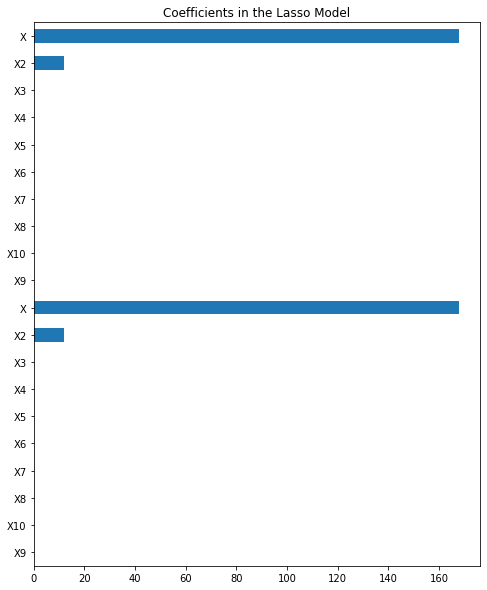

In [268]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

## (f)

In [279]:
#Change response Y
Y = 0.3 + 0.88*x**7 + e
y = pd.DataFrame(Y, columns=list('y'))
y = y.y


#Lasso regression
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005],cv=10).fit(X, y)

print(model_lasso)

LassoCV(alphas=[1, 0.1, 0.001, 0.0005], copy_X=True, cv=10, eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)


In [281]:
#Best Subset Selection
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = regsubsets(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

warnings.filterwarnings('ignore') #hide warnings

models_best

Processed 10 models on 1 predictors in 0.03441429138183594 seconds.
Processed 45 models on 2 predictors in 0.12182497978210449 seconds.
Processed 120 models on 3 predictors in 0.27187609672546387 seconds.
Processed 210 models on 4 predictors in 0.4809279441833496 seconds.
Processed 252 models on 5 predictors in 0.5653982162475586 seconds.
Processed 210 models on 6 predictors in 0.45142197608947754 seconds.
Processed 120 models on 7 predictors in 0.26282382011413574 seconds.
Total elapsed time: 2.2143051624298096 seconds.


,RSS,model
1,767.064707,<statsmodels.regression.linear_model.Regressio...
2,761.243972,<statsmodels.regression.linear_model.Regressio...
3,750.212961,<statsmodels.regression.linear_model.Regressio...
4,749.879708,<statsmodels.regression.linear_model.Regressio...
5,740.414794,<statsmodels.regression.linear_model.Regressio...
6,736.277321,<statsmodels.regression.linear_model.Regressio...
7,736.285923,<statsmodels.regression.linear_model.Regressio...


# #6.9

## (a)

In [234]:
College = sm.datasets.get_rdataset("College","ISLR").data

In [235]:
X = College.iloc[:,2:]
y = College.Apps

In [236]:
X.head()

,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [237]:
X_train,  X_test,  y_train,  y_test  =  train_test_split(X, y, random_state=0)

## (b)

In [238]:
#linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

#accuracy
lr.score(X_test, y_test)

0.9000457292126521

## (c)

In [239]:
#standardize X

scaler = StandardScaler()

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test) 

In [242]:
#Ridge regression
rcv = RidgeCV(alphas=np.linspace(.01, 100, 1000),  cv=10)

rcv.fit(X_train_scaled, y_train)

#accuracy
rcv.score(X_test_scaled,y_test)
warnings.filterwarnings('ignore') #hide warnings

0.9032328113611048

## (d)

In [48]:
#Lasso regression
lcv = LassoCV(alphas=np.linspace(.01, 100, 1000),  cv=10)

lcv.fit(X_train_scaled, y_train) 

#accuracy
lcv.score(X_test_scaled,y_test)

0.9000490350110231

## (e)

In [53]:
#Principal Component Regression
from sklearn.decomposition import PCA

pca = PCA()

# Run PCA producing the reduced variable Xreg and select the first pc components
X_reduced_train = pca.fit_transform(X_train_scaled)

X_reduced_test = pca.fit_transform(X_test_scaled)

lr.fit(X_reduced_train, y_train)

#accuracy
lr.score(X_reduced_test, y_test)

0.44792060717782123

## (f)

In [50]:
#Partial Least Squares Regression
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=5)

pls.fit(X_train_scaled, y_train)

#accuracy
pls.score(X_test_scaled,y_test)

0.907573557280662

## (g)

The accuracy are not much different but PCR. The PLR seems to perform better than the others.

# #6.10

## (a)

In [3]:
#Create a data set
np.random.seed(0)

# Dataframe with random numbers and the specified dimensions
n = 1000
p = 20
X = pd.DataFrame(np.random.normal(size=(n, p)))

# Epsilon
e = np.random.normal(size=n)

# Coefficient b1
b1 = np.random.normal(size=p)
# Random number of b1 elements with value zero
for i in range(0, np.random.randint(0,p)):
    b1[np.random.randint(0,p)] = 0

# model
y = np.dot(X, b1) + e

## (b)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .9)

## (c)

In [26]:
#Best Subset Selection
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score

def getRSS_validation(y_train, X_train, y_test, X_test,  feature_list):
    model = sm.OLS(y_train, X_train[list(feature_list)]).fit()
    RSS = ((model.predict(X_test[list(feature_list)]) - y_test) ** 2).sum()
    return {'Model':model, "RSS":RSS}

def bestModel_validation(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_validation(y_train, X_train, y_test, X_test, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].argmin()] ## this could be modified to have the top several models
    return best_model

In [27]:
max_feature = 3

models_validation = pd.DataFrame(columns=["RSS", "Model"])
for i in range(1,(max_feature+1)):  # for illustration purpuse, I just run for 1 - max_fearure features 
    models_validation.loc[i] = bestModel_validation(y_train, X_train, y_test, X_test, i) 
    
warnings.filterwarnings('ignore') #hide warnings

## (d)

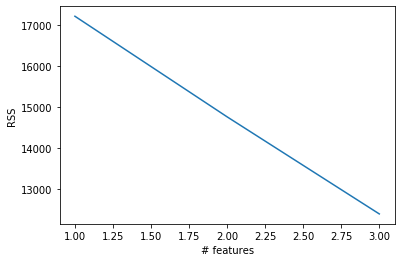

In [17]:
plt.figure()
plt.plot(models_validation["RSS"])
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

## (e)

In [31]:
print('Best max_feature variable from best subset selection on traning and validation split')
print (models_validation.loc[max_feature, 'Model'].params)

Best max_feature variable from best subset selection on traning and validation split
1    -1.500438
3     2.136651
15    2.027191
dtype: float64


## (f)

In [32]:
k = 10
np.random.seed(seed = 21)
train_index = np.random.choice(k, size = len(y), replace = True)  # Randomly assign each observations into folds
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X.columns) + 1))

models_cv = pd.DataFrame(columns=["RSS", "Model"])
for j in range(1,k+1):
    feature_list = []
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward_select_validation(y[train_index!= (j-1)], X[train_index != (j-1)], 
                                                     y[train_index == (j-1)],X[train_index == (j-1)], 
                                                     feature_list)
        
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = models_cv.loc[i]["Model"].model.exog_names

In [34]:
print(models_cv.loc[5, "Model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.570
Model:                            OLS   Adj. R-squared (uncentered):              0.567
Method:                 Least Squares   F-statistic:                              232.1
Date:                Fri, 13 Mar 2020   Prob (F-statistic):                   9.63e-158
Time:                        17:12:14   Log-Likelihood:                         -2253.3
No. Observations:                 881   AIC:                                      4517.
Df Residuals:                     876   BIC:                                      4541.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## (g)

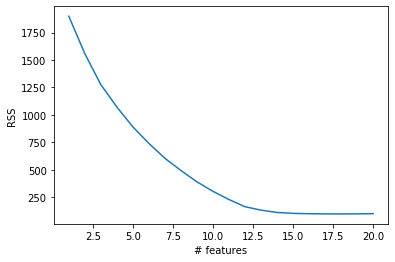

In [33]:
cv_errors_mean = cv_errors.mean(axis = 1)
plt.figure()
plt.plot(cv_errors_mean)
plt.xlabel('# features')
plt.ylabel('RSS')
plt.show()

# #6.11

In [63]:
Boston = sm.datasets.get_rdataset("Boston","MASS").data

## (a)

In [64]:
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [158]:
y = Boston.crim
X = Boston.iloc[:,1:]

X_train,  X_test,  y_train,  y_test  =  train_test_split(X, y, random_state=0)

In [159]:
#Best Subset Selection 
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def regsubsets(k):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [160]:
models_best = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,8):
    models_best.loc[i] = regsubsets(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

/Users/jason13nn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Processed 13 models on 1 predictors in 0.05172896385192871 seconds.
Processed 78 models on 2 predictors in 0.20470213890075684 seconds.
Processed 286 models on 3 predictors in 0.7506909370422363 seconds.
Processed 715 models on 4 predictors in 2.198258876800537 seconds.
Processed 1287 models on 5 predictors in 3.4549171924591064 seconds.
Processed 1716 models on 6 predictors in 4.514233112335205 seconds.
Processed 1716 models on 7 predictors in 5.106358051300049 seconds.
Total elapsed time: 16.377593994140625 seconds.


In [81]:
#Best model
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                   crim   R-squared (uncentered):                   0.475
Model:                            OLS   Adj. R-squared (uncentered):              0.472
Method:                 Least Squares   F-statistic:                              170.5
Date:                Fri, 13 Mar 2020   Prob (F-statistic):                    1.81e-53
Time:                        12:48:53   Log-Likelihood:                         -1245.3
No. Observations:                 379   AIC:                                      2495.
Df Residuals:                     377   BIC:                                      2502.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [84]:
#Standardize X for Lasso, Ridge, and PCR regression
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [85]:
#Lasso regression
lcv = LassoCV(alphas=np.linspace(.01, 100, 1000),  cv=10)

lcv.fit(X_train_scaled, y_train) 

LassoCV(alphas=array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00, 1.51135135e+00,
       1.61144144e+00, 1.71153153e+00, 1.81162162e+00, 1.91171171e+00,
       2.01180180e+00, 2.11189189e+0...
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02]),
        copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [86]:
#Ridge regression
rcv = RidgeCV(alphas=np.linspace(.01, 100, 1000),  cv=10)

rcv.fit(X_train_scaled, y_train)

/Users/jason13nn/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeCV(alphas=array([1.00000000e-02, 1.10090090e-01, 2.10180180e-01, 3.10270270e-01,
       4.10360360e-01, 5.10450450e-01, 6.10540541e-01, 7.10630631e-01,
       8.10720721e-01, 9.10810811e-01, 1.01090090e+00, 1.11099099e+00,
       1.21108108e+00, 1.31117117e+00, 1.41126126e+00, 1.51135135e+00,
       1.61144144e+00, 1.71153153e+00, 1.81162162e+00, 1.91171171e+00,
       2.01180180e+00, 2.11189189e+0...
       9.80982883e+01, 9.81983784e+01, 9.82984685e+01, 9.83985586e+01,
       9.84986486e+01, 9.85987387e+01, 9.86988288e+01, 9.87989189e+01,
       9.88990090e+01, 9.89990991e+01, 9.90991892e+01, 9.91992793e+01,
       9.92993694e+01, 9.93994595e+01, 9.94995495e+01, 9.95996396e+01,
       9.96997297e+01, 9.97998198e+01, 9.98999099e+01, 1.00000000e+02]),
        cv=10, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [87]:
# Run PCA producing the reduced variable Xreg and select the first pc components
X_reduced_train = pca.fit_transform(X_train_scaled)

X_reduced_test = pca.fit_transform(X_test_scaled)

lr.fit(X_reduced_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## (b)

In [88]:
#accuracy for Lasso
lcv.score(X_test_scaled,y_test)

0.4327626140028401

In [89]:
#accuracy for Ridge
rcv.score(X_test_scaled,y_test)

0.4255239919763707

Probably choose the lasso model because its test MSE is close to best and eliminates some predictors to reduce model complexity.

## (c)

No. Not all the predictors add much value to the model.